##### Extraction des caractéristiques prediction et calcul du taux de pauvreté sur l'ensemble training en milieu rural

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

X = 50
moitiequarts = 'moitie'
Y = 100
Data_milieu='Data_rural'

#2 Définit les chemins et charge les données.


BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
COUNTRIES_DIR = os.path.join(BASE_DIR, f'{Data_milieu}','CIV')
PROCESSED_DIR = os.path.join(BASE_DIR,f'{Data_milieu}', 'processed') 

RESULTS_DIR = os.path.join(BASE_DIR,f'{Data_milieu}','results')
CNN_TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, f'{Data_milieu}/cnn_images_{X}m_{moitiequarts}_IPM_{Y}')


CNN_SAVE_DIR = os.path.join(BASE_DIR, f'{Data_milieu}',f'models_{X}m_{moitiequarts}_IPM_{Y}')
                                                                             

CNN_DIR = os.path.join(CNN_SAVE_DIR,f'trained_model_{X}m_{moitiequarts}_IPM_{Y}_vgg11bn.pt')

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, 'CIV_2018'), exist_ok=True)

df_images = pd.read_csv(os.path.join(PROCESSED_DIR, f'image_download_actual_{X}m_{moitiequarts}_IPM_{Y}.csv'))
df_images

#3 Charge et configure le modèle.
# Importe la bibliothèque PyTorch
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} as backend')
model = torch.load(CNN_DIR, map_location=device)
model.classifier = model.classifier[:4]
model.eval()
#4 Déclare une classe personnalisée pour le chargement rapide des images.

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class ForwardPassDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transformer):
        self.image_dir = image_dir
        self.image_list = os.listdir(self.image_dir)
        self.transformer = transformer

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_name = self.image_list[index]
        X = self.filename_to_im_tensor(self.image_dir + '/' + image_name)
        return X, -1
    
    def filename_to_im_tensor(self, file):
        im = plt.imread(file)[:, :, :3]
        im = self.transformer(im)
        return im

#Définit une fonction pour extraire les caractéristiques à partir des images.

def extract_features(image_dir, classes, model, transformer, device):
    features = []
    image_order = []
    for c in classes:
        dataset = ForwardPassDataset(os.path.join(image_dir, str(c)), transformer)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0)
        image_order += dataset.image_list
        for inputs, _ in tqdm(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().detach().numpy())
    features = np.vstack(features)
    return features, image_order


classes = [0, 1, 2, 3, 4, 5]



In [ ]:
#5 Extrait les caractéristiques pour les ensembles de validation et d'entraînement.

# Extraction des features pour le set d'entraînement
feats_training, image_order_training = extract_features(os.path.join(CNN_TRAIN_IMAGE_DIR, f'train_{X}m_{moitiequarts}_IPM_{Y}'), classes, model, transformer, device)
print("Dimensions de 'feats_training':", feats_training.shape)

In [ ]:
df_images

In [ ]:
# Création du DataFrame pour le set d'entraînement
df_train = pd.DataFrame({
    'image_name': image_order_training,
    'feat_index': np.arange(len(image_order_training))
})

# Fusion du DataFrame df_train avec df_images sur 'image_name'
df_consumption_train = pd.merge(df_images, df_train, on='image_name')

# Ajout des caractéristiques au DataFrame df_consumption_train
for i in range(feats_training.shape[1]):
    df_consumption_train[f'feature_{i}'] = feats_training[df_consumption_train['feat_index'], i]

# Sauvegarde du DataFrame df_consumption_train
output_train_path = os.path.join(BASE_DIR, f'df_consumption_train_{X}m_{moitiequarts}_IPM_{Y}_{Data_milieu}.csv')
df_consumption_train.to_csv(output_train_path, index=False)
print(f"DataFrame pour le set d'entraînement sauvegardé à {output_train_path}") 


In [ ]:
df_consumption_train

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy


In [3]:
X = 50
moitiequarts = 'moitie'
Y = 100
Data_milieu='Data_rural'

In [4]:
# Définir le chemin de base et charger les données
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
data_path = os.path.join(BASE_DIR, f'df_consumption_train_{X}m_{moitiequarts}_IPM_{Y}_{Data_milieu}.csv')
df = pd.read_csv(data_path)
#df


In [5]:
# Préparer les données
X_rural_train = df.iloc[:, 11:]  # Les caractéristiques
y = df.iloc[:, 7]   # 'pcexp'


In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

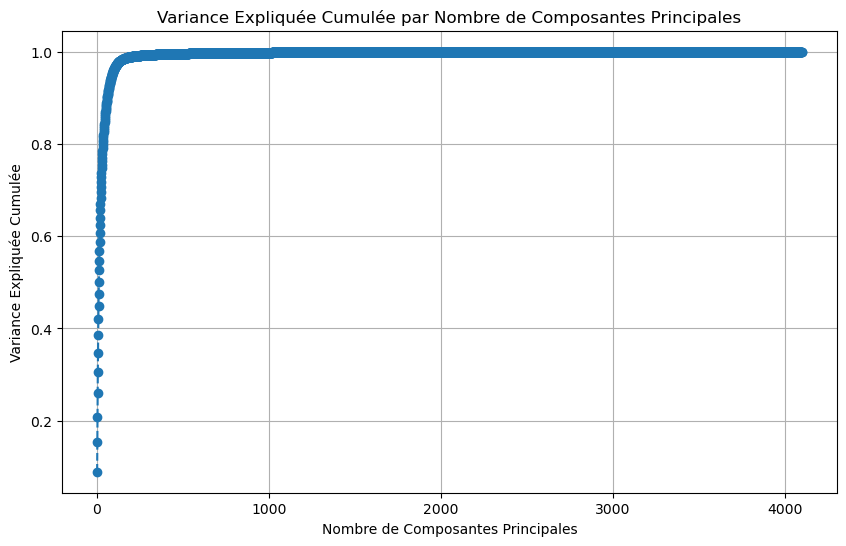

Nombre optimal de composantes principales pour expliquer 95.0% de la variance: 87


In [7]:
# Normalisation des caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rural_train)


# Appliquer PCA sans limiter le nombre de composantes
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculer la variance expliquée cumulée
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Tracer la variance expliquée cumulée
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Nombre de Composantes Principales')
plt.ylabel('Variance Expliquée Cumulée')
plt.title('Variance Expliquée Cumulée par Nombre de Composantes Principales')
plt.grid(True)
plt.show()
# Choisir le nombre de composantes pour expliquer 95% de la variance
threshold = 0.95
n_components_optimal = np.argmax(explained_variance_ratio >= threshold) + 1
print(f'Nombre optimal de composantes principales pour expliquer {threshold * 100}% de la variance: {n_components_optimal}')


# Appliquer PCA avec le nombre optimal de composantes
pca = PCA(n_components=n_components_optimal)
X_pca = pca.fit_transform(X_scaled)


In [8]:
X_pca.shape

(128800, 87)

In [9]:
print(X_pca)

[[ 36.58842006   3.8699993    4.03807488 ...   0.5591509   -0.29080896
    1.14066062]
 [ 12.87905896  -2.19934635   1.83823941 ...  -2.25046776  -1.75172048
    2.16625227]
 [ 14.28226397   1.70064056   1.77765188 ...  -0.91326812  -0.83756793
    1.04498251]
 ...
 [-20.06325253   3.71501737  -6.68463605 ...  -2.06396749   2.35590854
    0.32273172]
 [-14.67214583   5.67950597 -14.91005102 ...  -0.09205785   0.93557331
    2.59107467]
 [-21.66397338   4.13580262  -8.67537992 ...   0.74109166  -0.1094486
    0.91913005]]


In [10]:
#Variance expliquée par chaque composante
pca = PCA(n_components=n_components_optimal)
X_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)

[0.08951577 0.06375047 0.05540402 0.05092569 0.04513975 0.04135135
 0.03888447 0.03496406 0.02900011 0.02689707 0.02555474 0.02445556
 0.02152832 0.02052686 0.02041378 0.01829696 0.01701274 0.01658871
 0.01560247 0.01372075 0.01345884 0.01259756 0.01116801 0.0108545
 0.0102012  0.01004003 0.00906633 0.00820566 0.00781248 0.00766093
 0.00724664 0.00677316 0.00648185 0.00646663 0.00602335 0.00565121
 0.00556287 0.0054525  0.00510533 0.00484463 0.00476027 0.00462473
 0.00449689 0.00438928 0.00425896 0.00410045 0.00396643 0.00385441
 0.0036506  0.0035756  0.00339808 0.00327446 0.00316862 0.00306751
 0.00302526 0.00290017 0.0027885  0.00275894 0.00271076 0.00262905
 0.0024541  0.00242801 0.00236401 0.00235676 0.00231491 0.0022237
 0.00216966 0.00200551 0.00196452 0.00193777 0.00189136 0.00186254
 0.00181632 0.00180491 0.00172203 0.001693   0.00157851 0.00156439
 0.00150494 0.00147203 0.00143265 0.00140401 0.00136181 0.00134052
 0.00126889 0.00124934 0.00122925]


In [11]:
X_pca

array([[ 36.58842006,   3.8699993 ,   4.03807488, ...,   0.46476481,
         -0.46255675,   1.42191549],
       [ 12.87905896,  -2.19934635,   1.83823941, ...,  -2.73576342,
         -1.69089371,   2.18276998],
       [ 14.28226397,   1.70064056,   1.77765188, ...,  -1.21418247,
         -0.83703585,   1.17061882],
       ...,
       [-20.06325253,   3.71501737,  -6.68463605, ...,  -2.31151578,
          2.51280038,   0.61469942],
       [-14.67214583,   5.67950597, -14.91005102, ...,  -0.36592659,
          1.03181988,   2.80861367],
       [-21.66397338,   4.13580262,  -8.67537992, ...,   0.6842306 ,
         -0.09412413,   1.11226228]])

In [12]:
coefficients_des_composantes_principales=pca.components_

In [13]:
coefficients_des_composantes_principales

array([[-0.00744547, -0.02210326, -0.00335841, ..., -0.00754587,
        -0.02246198, -0.00239346],
       [ 0.00798041,  0.00076747, -0.01094985, ...,  0.0242604 ,
         0.00058393, -0.02330592],
       [ 0.00783831,  0.01001967, -0.00202857, ...,  0.02345588,
         0.01011731,  0.01379105],
       ...,
       [ 0.01113942, -0.00287078, -0.02505268, ..., -0.00542584,
         0.00201631,  0.00763629],
       [ 0.00105004, -0.03289475, -0.02210265, ...,  0.00060274,
        -0.02528683,  0.0314386 ],
       [-0.00886414, -0.01062844, -0.00422286, ..., -0.01127469,
        -0.0048667 ,  0.01357313]])

In [14]:
coefficients_des_composantes_principales.shape

(87, 4096)

In [15]:
y.shape

(128800,)

### OLS sur le X_pca

In [16]:
from sklearn.linear_model import LinearRegression

#le modèle de régression linéaire à X_pca en tant que prédicteurs et y comme variable cible.
linear_model_pca = LinearRegression()
linear_model_pca.fit(X_pca, y)

#les coefficients de la régression
coefficients = linear_model_pca.coef_
print("Coefficients du modèle :", coefficients)



Coefficients du modèle : [ 1222.84737591  -905.78455128   795.58697711  1613.9363538
  1670.22131819  -371.80684124   704.67081017   195.46743107
 -1958.79018358  1073.11167042 -1515.4340289    133.34291813
 -1903.42095242 -1003.63400402  -981.1117161   2380.26969561
  2434.39292609   788.22639269    42.56880874  -545.42844613
   291.71504356  -559.31030571   -24.69499879 -1044.27132606
  -366.21773373   863.86089106    51.11081267   408.07435537
  2940.3814939   4229.45245427  1500.77519074  -893.18489599
   485.29779917  1961.43216892  -726.46321712  1940.65884599
   112.71418169 -1341.67116103  2865.64863486  2888.25380205
  1163.63964294  1333.597643   -1271.58023768    95.22681335
 -2200.11469267 -3840.78831715 -1851.88960082  -540.62174436
 -1240.31573094 -1420.21544136   394.11711825  1547.05621445
  -374.58423531  -922.20450452 -1841.69602794 -1374.09759173
 -2456.91170392 -1816.70450513   462.48658867   396.83225065
 -1819.47342293   987.95521375  1116.70446483  1750.61511259


In [17]:
#Résumé complet de la regression avec stats model
import statsmodels.api as sm

# Ajout d'un intercept à X_pca
X_pca_sm = sm.add_constant(X_pca)

# Ajustement du modèle avec statsmodels
model_sm = sm.OLS(y, X_pca_sm)
results = model_sm.fit()

# Affichage du résumé
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                  pcexp   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     116.7
Date:                Thu, 29 Aug 2024   Prob (F-statistic):               0.00
Time:                        11:42:07   Log-Likelihood:            -1.8121e+06
No. Observations:              128800   AIC:                         3.624e+06
Df Residuals:                  128712   BIC:                         3.625e+06
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.713e+05    869.299    542.174      0.0

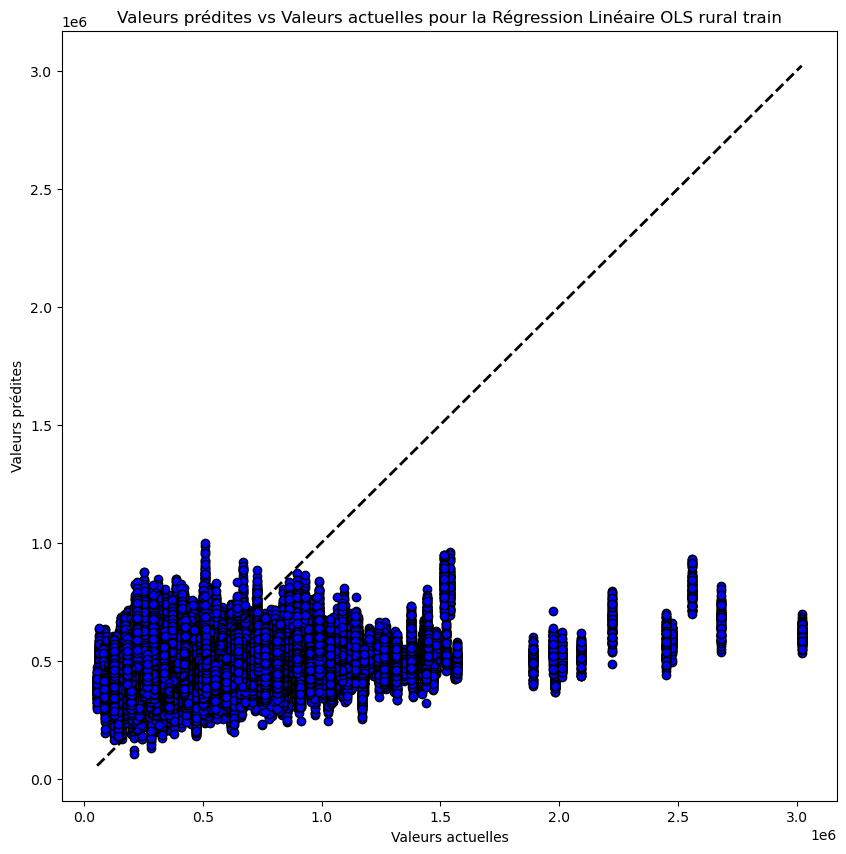

In [18]:
# Prédictions du modèle linéaire
y_pred_OLS = linear_model_pca.predict(X_pca)

# Graphique montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 10))
plt.scatter(y, y_pred_OLS, alpha=1, color='blue', edgecolors='Black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la Régression Linéaire OLS rural train')
plt.show()

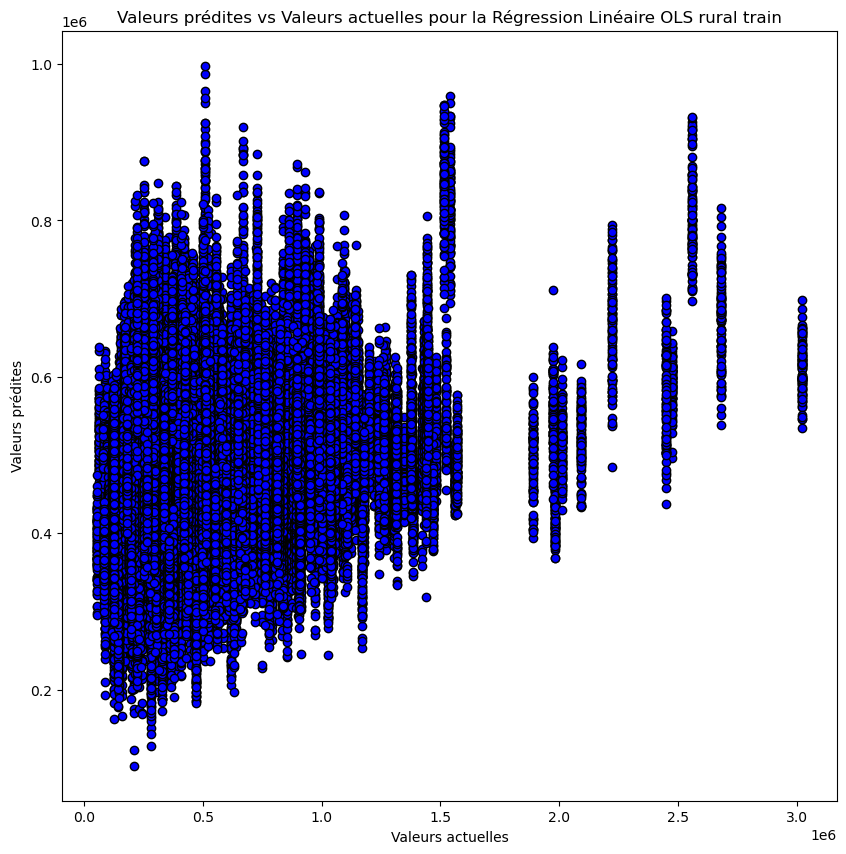

In [19]:
# Graphique montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 10))
plt.scatter(y, y_pred_OLS, alpha=1, color='blue', edgecolors='Black')
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la Régression Linéaire OLS rural train')
plt.show()

In [20]:
#Exportation du modèle OLS de statsmodels avec pca pour ré-utilisation 
import pickle
# Chemin de sauvegarde du modèle
model_sm_path = f'{BASE_DIR}\\{Data_milieu}\\model_sm_pca.pkl'
# Sauvegarder le modèle statsmodels
with open(model_sm_path, 'wb') as file:
    pickle.dump(results, file)
print(f'Modèle statsmodels sauvegardé à: {model_sm_path}')

Modèle statsmodels sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_rural\model_sm_pca.pkl


In [21]:
'''
#Chargement du modèle OLS de statsmodels qui a été importé pour ré-utilisation 
# Chemin de sauvegarde du modèle
model_sm_path = f'{BASE_DIR}\\{Data_milieu}\\model_sm_pca.pkl'
# Recharger le modèle OLS librairie statsmodels
with open(model_sm_path, 'rb') as file:
    model_sm_loaded = pickle.load(file)
print("Modèle OLS de la bibliothèque statsmodels chargé avec succès.")
'''

'\n#Chargement du modèle OLS de statsmodels qui a été importé pour ré-utilisation \n# Chemin de sauvegarde du modèle\nmodel_sm_path = f\'{BASE_DIR}\\{Data_milieu}\\model_sm_pca.pkl\'\n# Recharger le modèle OLS librairie statsmodels\nwith open(model_sm_path, \'rb\') as file:\n    model_sm_loaded = pickle.load(file)\nprint("Modèle OLS de la bibliothèque statsmodels chargé avec succès.")\n'

### Ridge regression sur le X_pca

In [22]:
#Modèle de régression Ridge avec scikit-learn

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-6, 6, 200)

# Configuration initiale et recherche du meilleur alpha avec GridSearchCV
ridge_model = Ridge()
ridge_cv = GridSearchCV(ridge_model, {'alpha': alphas}, scoring='r2', cv=5)
ridge_cv.fit(X_pca, y)

# Meilleure valeur de alpha pour Ridge
best_alpha_ridge = ridge_cv.best_estimator_.alpha
print(f'Best alpha for Ridge: {best_alpha_ridge}')

Best alpha for Ridge: 1000000.0


In [24]:
# Entraîner le modèle de régression Ridge avec la meilleure valeur de alpha
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_pca, y)

# Extraction et affichage des coefficients du modèle Ridge
coefficients_ridge = ridge_model.coef_
print("Coefficients du modèle Ridge:", coefficients_ridge)

Coefficients du modèle Ridge: [ 1197.49044591  -879.63037687   769.26849357  1556.01984368
  1602.91207637  -355.51061531   671.91687123   185.41552523
 -1838.61486186  1002.46549469 -1410.78984225   123.75120785
 -1749.39237616  -918.79059131  -897.75184741  2156.82957774
  2190.35145414   707.39609802    37.95745924  -479.22429984
   255.70266687  -486.159865     -21.11177973  -889.02289567
  -308.83298271   726.6696843     42.27281683   331.49842753
  2366.26630413  3390.54767661  1189.60953794  -697.87993138
   375.49192917  1516.82086313  -552.57280597  1453.22482532
    84.06851715  -995.57175506  2089.76308921  2076.00096686
   832.2457281    945.90620252  -894.52505882    66.50621798
 -1522.50542771 -2626.59821427 -1253.06638956  -362.40181151
  -816.41060775  -928.17149541   252.99354308   979.84728785
  -234.37729849  -569.99088274 -1132.26583991  -830.98227874
 -1462.65987676 -1076.8586416    272.17080066   230.58444088
 -1026.56921106   554.81919156   619.76562347   970.254

In [25]:
# Prédictions Ridge
y_pred_ridge = ridge_model.predict(X_pca)

# Évaluation du modèle Ridge
mse_pca_ridge = mean_squared_error(y, y_pred_ridge)
r2_pca_ridge = r2_score(y, y_pred_ridge)
mae_pca_ridge = mean_absolute_error(y, y_pred_ridge)

print(f'Ridge Train MSE: {mse_pca_ridge}')
print(f'Ridge Train MAE: {mae_pca_ridge}')
print(f'Ridge Train R^2: {r2_pca_ridge}')

Ridge Train MSE: 97721592778.12471
Ridge Train MAE: 218926.72936320226
Ridge Train R^2: 0.06875537569280687


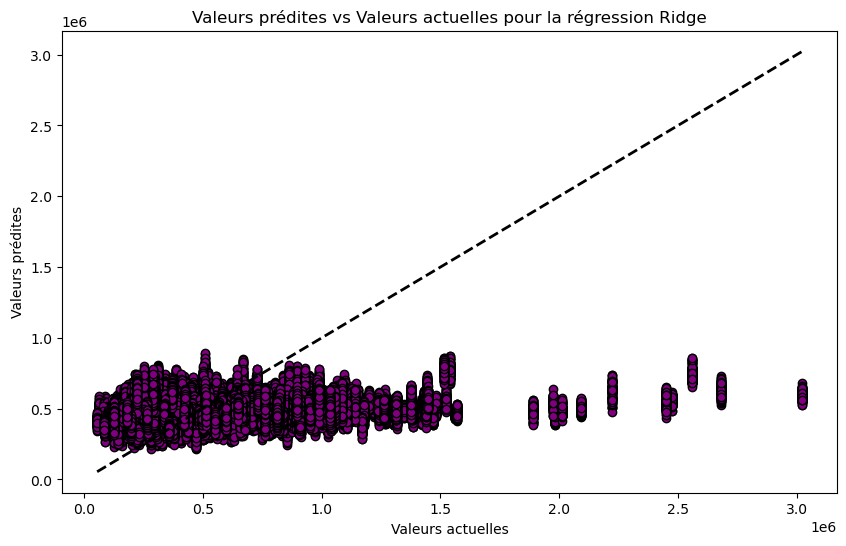

In [26]:
# Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_ridge, alpha=1,color='purple', edgecolors='Black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Ridge')
plt.show()

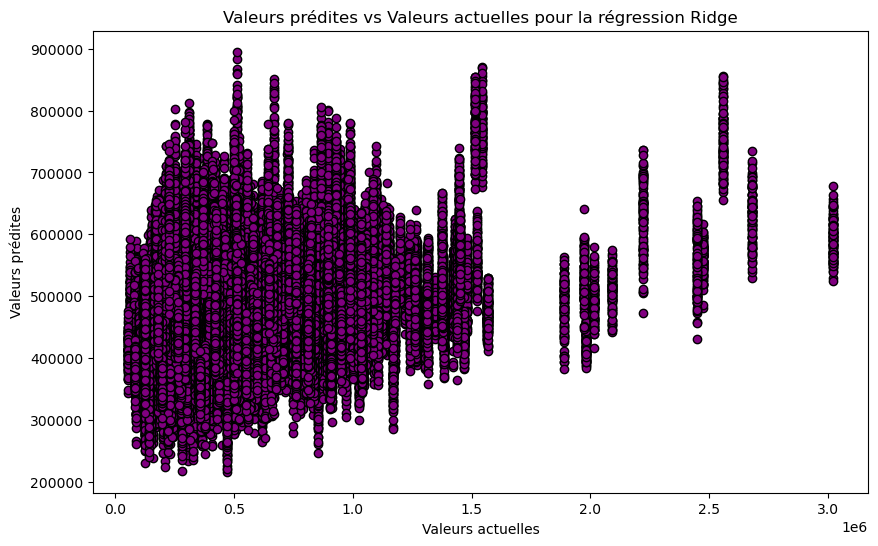

In [27]:
# Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_ridge, alpha=1,color='purple', edgecolors='Black')
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Ridge')
plt.show()

In [28]:
#Exportation du modèle ridge pour ré-utilisation
import joblib
# Chemin de sauvegarde du modèle
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
model_path_ridge = f'{BASE_DIR}\\{Data_milieu}\\ridge_model_pca.pkl'

# Sauvegarder le modèle Ridge
joblib.dump(ridge_model, model_path_ridge)
print(f'Modèle sauvegardé à: {model_path_ridge}')


Modèle sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_rural\ridge_model_pca.pkl


In [29]:
'''
#Chargement du modèle Ridge qui a été importé pour ré-utilisation 
# Chemin de sauvegarde du modèle
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
model_path_ridge = f'{BASE_DIR}\\{Data_milieu}\\ridge_model_pca.pkl'
# Recharger le modèle Ridge
ridge_model_loaded = joblib.load(model_path_ridge)
print("Modèle de Ridge chargé avec succès.")
ridge_model_loaded.coef_
'''

'\n#Chargement du modèle Ridge qui a été importé pour ré-utilisation \n# Chemin de sauvegarde du modèle\nBASE_DIR = r\'D:\\Poverty_Predict_Par_Milieu\'\nmodel_path_ridge = f\'{BASE_DIR}\\{Data_milieu}\\ridge_model_pca.pkl\'\n# Recharger le modèle Ridge\nridge_model_loaded = joblib.load(model_path_ridge)\nprint("Modèle de Ridge chargé avec succès.")\nridge_model_loaded.coef_\n'

### Lasso sur le X_pca

In [30]:
#Regression Lasso
# Modèle de régression Lasso avec scikit-learn

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-6, 6, 200)

# Configuration initiale et recherche du meilleur alpha avec GridSearchCV
lasso_model = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso_model, {'alpha': alphas}, scoring='r2', cv=5)
lasso_cv.fit(X_pca, y)

# Meilleure valeur de alpha pour Lasso
best_alpha_lasso = lasso_cv.best_estimator_.alpha
print(f'Best alpha for Lasso: {best_alpha_lasso}')

Best alpha for Lasso: 71494.28986597562


In [32]:
# Entraîner le modèle de régression Lasso avec la meilleure valeur de alpha
lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_model.fit(X_pca, y)

# Extraction et affichage des coefficients du modèle Lasso
coefficients_lasso = lasso_model.coef_
print("Coefficients du modèle Lasso:", coefficients_lasso)


Coefficients du modèle Lasso: [ 1027.85760254  -631.98797283   480.54375838  1271.18871363
  1283.54086621    -0.           255.78569052     0.
 -1356.90764095   424.16883179  -832.40367764     0.
 -1092.64419297  -153.30144255  -126.06875886  1426.30447632
  1408.41728403     0.             0.            -0.
     0.            -0.            -0.            -0.
    -0.             0.             0.             0.
   706.17845656  1951.05213966     0.            -0.
     0.             0.            -0.             0.
     0.            -0.             0.             0.
     0.             0.            -0.             0.
    -0.            -0.            -0.            -0.
    -0.            -0.             0.             0.
    -0.            -0.            -0.            -0.
    -0.            -0.             0.             0.
    -0.             0.             0.             0.
    -0.             0.             0.             0.
     0.            -0.             0.             0.


In [33]:
# Prédictions Lasso
y_pred_lasso = lasso_model.predict(X_pca)

# Évaluation du modèle Lasso
mse_pca_lasso = mean_squared_error(y, y_pred_lasso)
r2_pca_lasso = r2_score(y, y_pred_lasso)
mae_pca_lasso = mean_absolute_error(y, y_pred_lasso)

print(f'Lasso Train MSE: {mse_pca_lasso}')
print(f'Lasso Train MAE: {mae_pca_lasso}')
print(f'Lasso Train R^2: {r2_pca_lasso}')


Lasso Train MSE: 100831560679.0887
Lasso Train MAE: 221374.61431482938
Lasso Train R^2: 0.03911872316590537


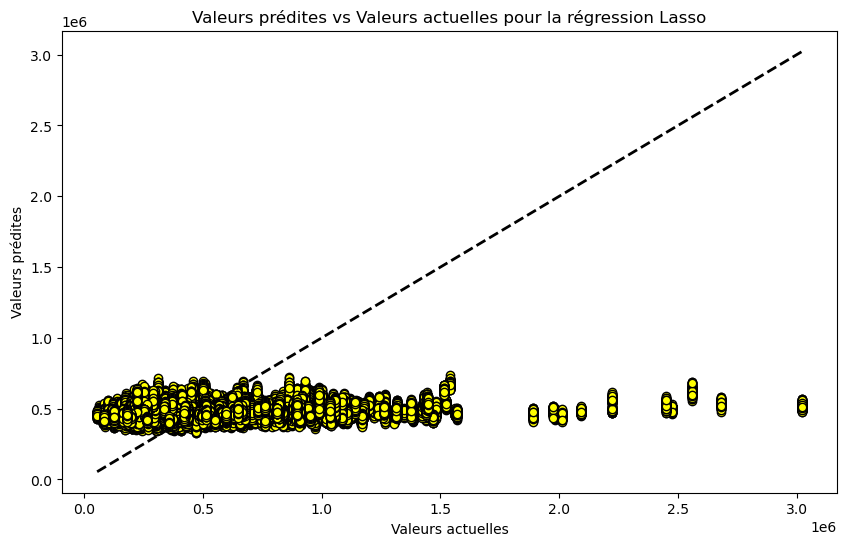

In [34]:
# Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_lasso, alpha=1, color='yellow', edgecolors='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Lasso')
plt.show()

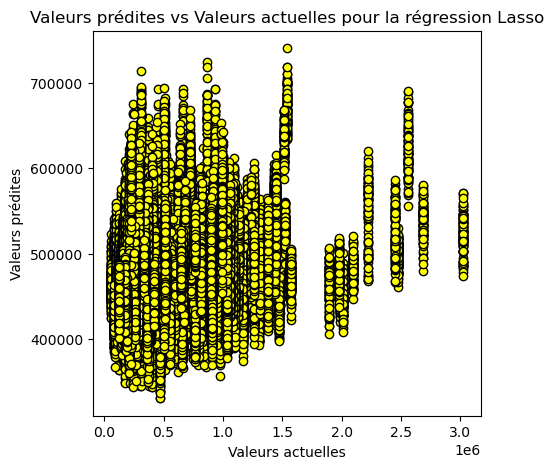

In [35]:
# Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred_lasso, alpha=1, color='yellow', edgecolors='black')
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Lasso')
plt.show()

In [36]:
#Exportation du modèle Lasso pour ré-utilisation
import joblib
# Chemin de sauvegarde du modèle Lasso
lasso_model_path = f'{BASE_DIR}\\{Data_milieu}\\lasso_model_pca.pkl'
# Sauvegarder le modèle Lasso
joblib.dump(lasso_model, lasso_model_path)
print(f'Modèle Lasso sauvegardé à: {lasso_model_path}')

Modèle Lasso sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_rural\lasso_model_pca.pkl


In [37]:
'''
#Chargement du modèle Lasso qui a été importé pour ré-utilisation 
import joblib
# Chemin de sauvegarde du modèle Lasso
lasso_model_path = f'{BASE_DIR}\\{Data_milieu}\\lasso_model_pca.pkl'
# Recharger le modèle Lasso
lasso_model_loaded = joblib.load(lasso_model_path)
print("Modèle Lasso chargé avec succès.")
lasso_model_loaded.coef_
'''

'\n#Chargement du modèle Lasso qui a été importé pour ré-utilisation \nimport joblib\n# Chemin de sauvegarde du modèle Lasso\nlasso_model_path = f\'{BASE_DIR}\\{Data_milieu}\\lasso_model_pca.pkl\'\n# Recharger le modèle Lasso\nlasso_model_loaded = joblib.load(lasso_model_path)\nprint("Modèle Lasso chargé avec succès.")\nlasso_model_loaded.coef_\n'

In [38]:
PROCESSED_DIR = os.path.join(BASE_DIR,f'{Data_milieu}', 'processed') 
df_images = pd.read_csv(os.path.join(PROCESSED_DIR, f'image_download_actual_{X}m_{moitiequarts}_IPM_{Y}.csv'))
df_images

,image_name,menage_lat,menage_lon,grappe,hhweight,hhsize,is_train,pcexp,nightlights_50m,nightlights_50m_bins
0,10.0003794_-5.5802424_1.png,10.000379,-5.580242,1047,268.36096,4,False,274696.28,2.232362,4
1,10.0003794_-5.5802424_10.png,10.000379,-5.580242,1047,268.36096,4,False,274696.28,2.232362,4
2,10.0003794_-5.5802424_100.png,10.000379,-5.580242,1047,268.36096,4,False,274696.28,2.232362,4
3,10.0003794_-5.5802424_11.png,10.000379,-5.580242,1047,268.36096,4,False,274696.28,2.232362,4
4,10.0003794_-5.5802424_12.png,10.000379,-5.580242,1047,268.36096,4,False,274696.28,2.232362,4
...,...,...,...,...,...,...,...,...,...,...
770995,9.9994593_-5.5801466_95.png,9.999459,-5.580147,1047,268.36096,1,False,1239198.10,2.232362,4
770996,9.9994593_-5.5801466_96.png,9.999459,-5.580147,1047,268.36096,1,False,1239198.10,2.232362,4
770997,9.9994593_-5.5801466_97.png,9.999459,-5.580147,1047,268.36096,1,False,1239198.10,2.232362,4
770998,9.9994593_-5.5801466_98.png,9.999459,-5.580147,1047,268.36096,1,False,1239198.10,2.232362,4


In [39]:
original_data=pd.read_csv(r'D:\Poverty_Predict_Par_Milieu\rural_data.csv')


In [40]:
original_data

,country,year,hhid,grappe,menage,vague,zae,region,milieu,milieu2,...,localisation_menage,nightlights_100m,nightlights_0m,nightlights_50m,nightlights_20m,nightlights_25m,nightlights_30m,nightlights_150m,nightlights_1000m,nightlights_5000m
0,CIV,2018,8101.0,81,1,1,SUD-EST,AUTONOME D'ABIDJAN,Rural,Rural,...,NaN,7.117401,7.117401,7.117401,7.117401,7.117401,7.117401,7.117401,6.054019,1.987207
1,CIV,2018,8103.0,81,3,1,SUD-EST,AUTONOME D'ABIDJAN,Rural,Rural,...,NaN,10.430248,7.117401,10.430248,7.117401,7.117401,10.430248,10.430248,6.950598,1.987207
2,CIV,2018,8104.0,81,4,1,SUD-EST,AUTONOME D'ABIDJAN,Rural,Rural,...,NaN,10.430248,13.743094,13.743094,13.743094,13.743094,13.743094,10.430248,6.950598,1.987207
3,CIV,2018,8105.0,81,5,1,SUD-EST,AUTONOME D'ABIDJAN,Rural,Rural,...,NaN,10.430248,13.743094,13.743094,13.743094,13.743094,13.743094,10.430248,8.473836,1.987207
4,CIV,2018,8106.0,81,6,1,SUD-EST,AUTONOME D'ABIDJAN,Rural,Rural,...,NaN,10.430248,13.743094,13.743094,13.743094,13.743094,13.743094,10.430248,8.473836,2.118229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,CIV,2019,108408.0,1084,8,2,CENTRE,MORONOU,Rural,Rural,...,NaN,2.226889,2.226889,2.226889,2.226889,2.226889,2.226889,2.226889,1.216256,0.373293
7708,CIV,2019,108409.0,1084,9,2,CENTRE,MORONOU,Rural,Rural,...,NaN,1.353545,1.055968,1.055968,1.055968,1.055968,1.055968,1.353545,0.971783,0.366489
7709,CIV,2019,108410.0,1084,10,2,CENTRE,MORONOU,Rural,Rural,...,NaN,1.651123,1.651123,1.651123,1.651123,1.651123,1.651123,1.111005,1.099275,0.364386
7710,CIV,2019,108411.0,1084,11,2,CENTRE,MORONOU,Rural,Rural,...,NaN,1.111005,0.570887,0.570887,0.570887,0.570887,0.570887,1.111005,0.901179,0.364386


In [41]:
original_data.columns

Index(['country', 'year', 'hhid', 'grappe', 'menage', 'vague', 'zae', 'region',
       'milieu', 'milieu2', 'hhweight', 'hhsize', 'eqadu1', 'eqadu2',
       'hgender', 'hage', 'hmstat', 'hreligion', 'hnation', 'hethnie',
       'halfab', 'heduc', 'hdiploma', 'hhandig', 'hactiv7j', 'hactiv12m',
       'hbranch', 'hsectins', 'hcsp', 'dali', 'dnal', 'dtot', 'dtet', 'pcexp',
       'zref', 'def_spa', 'def_temp', 'decile', 'quintile', 'interview__key',
       'interview__id', 'GPS__Latitude', 'GPS__Longitude', 'GPS__Accuracy',
       'GPS__Altitude', 'GPS__Timestamp', 'nom_prenom_cm',
       'localisation_menage', 'nightlights_100m', 'nightlights_0m',
       'nightlights_50m', 'nightlights_20m', 'nightlights_25m',
       'nightlights_30m', 'nightlights_150m', 'nightlights_1000m',
       'nightlights_5000m'],
      dtype='object')

In [42]:
import pandas as pd

# Chargement des données
original_data =pd.read_csv(r'D:\Poverty_Predict_Par_Milieu\rural_data.csv')
df_consumption_train=pd.read_csv(os.path.join(BASE_DIR, f'df_consumption_train_{X}m_{moitiequarts}_IPM_{Y}_{Data_milieu}.csv'))

# Fusion des données sur la base de la latitude et longitude
df_merged = pd.merge(df_consumption_train, original_data[['GPS__Latitude', 'GPS__Longitude', 'hhsize','hhweight', 'grappe', 'pcexp']],
                     how='left',
                     left_on=['menage_lat', 'menage_lon'],
                     right_on=['GPS__Latitude', 'GPS__Longitude'])

# Vérification de la conformité des colonnes 'grappe' et 'pcexp'
# Ici, on pourrait afficher des statistiques ou faire une vérification plus complexe si nécessaire
check_grappe = (df_merged['grappe_x'] == df_merged['grappe_y']).all()
check_pcexp = (df_merged['pcexp_x'] == df_merged['pcexp_y']).all()

print(f"Conformité de 'grappe': {check_grappe}")
print(f"Conformité de 'pcexp': {check_pcexp}")

# Si les vérifications sont correctes, vous pouvez alors choisir de conserver uniquement les colonnes nécessaires
if check_grappe and check_pcexp:
    df_final = df_merged.drop(columns=['GPS__Latitude', 'GPS__Longitude', 'grappe_y', 'pcexp_y'])
    df_final.rename(columns={'grappe_x': 'grappe', 'pcexp_x': 'pcexp','hhweight_x':'hhweight',	'hhsize_x':'hhsize'}, inplace=True)
    # Sauvegarde du nouveau DataFrame
    df_final.to_csv(r'D:\Poverty_Predict_Par_Milieu\Updated_ConsumptionData_train_rural.csv', index=False)
else:
    print("Des incohérences ont été trouvées. Vérifiez les données sources ou les critères de fusion.")

Conformité de 'grappe': True
Conformité de 'pcexp': True


In [43]:
updated_df_consumption_train=pd.read_csv(r'D:\Poverty_Predict_Par_Milieu\Updated_ConsumptionData_train_rural.csv')

In [44]:
updated_df_consumption_train

,image_name,menage_lat,menage_lon,grappe,hhweight,hhsize,is_train,pcexp,nightlights_50m,nightlights_50m_bins,...,feature_4088,feature_4089,feature_4090,feature_4091,feature_4092,feature_4093,feature_4094,feature_4095,hhsize_y,hhweight_y
0,10.0020737_-5.5787912_1.png,10.002074,-5.578791,1047,268.36096,2,True,1117854.80,1.845840,4,...,-0.932901,0.560567,-0.643352,0.204535,-1.541027,-0.426967,-1.510321,-1.914946,2,268.36096
1,10.0020737_-5.5787912_10.png,10.002074,-5.578791,1047,268.36096,2,True,1117854.80,1.845840,4,...,-0.400689,0.668075,-0.007845,-0.441598,-1.414511,-0.673079,-1.216031,-1.576597,2,268.36096
2,10.0020737_-5.5787912_100.png,10.002074,-5.578791,1047,268.36096,2,True,1117854.80,1.845840,4,...,-0.021012,0.522456,0.067050,-0.234865,-1.167643,-0.574183,-1.404746,-1.606668,2,268.36096
3,10.0020737_-5.5787912_11.png,10.002074,-5.578791,1047,268.36096,2,True,1117854.80,1.845840,4,...,-0.470614,0.748172,-0.599932,-0.041690,-1.776781,0.036928,-1.815925,-1.871191,2,268.36096
4,10.0020737_-5.5787912_12.png,10.002074,-5.578791,1047,268.36096,2,True,1117854.80,1.845840,4,...,-1.018350,0.689862,-0.513337,-0.186608,-2.056571,-0.354066,-2.014292,-1.817084,2,268.36096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128795,9.99561910517514_-5.34070671536028_95.png,9.995619,-5.340707,1056,220.62573,15,True,124090.74,0.243343,2,...,-0.663366,0.039058,0.063824,-0.951913,0.523509,-0.431161,-0.745200,-1.478782,15,220.62573
128796,9.99561910517514_-5.34070671536028_96.png,9.995619,-5.340707,1056,220.62573,15,True,124090.74,0.243343,2,...,-1.140294,0.971673,-0.170205,0.335568,-0.019138,-0.730070,-0.053027,-1.756807,15,220.62573
128797,9.99561910517514_-5.34070671536028_97.png,9.995619,-5.340707,1056,220.62573,15,True,124090.74,0.243343,2,...,-0.244845,0.320603,0.498894,-1.119498,0.948168,-0.292980,-0.717686,-1.301376,15,220.62573
128798,9.99561910517514_-5.34070671536028_98.png,9.995619,-5.340707,1056,220.62573,15,True,124090.74,0.243343,2,...,-1.539259,1.106363,0.388689,0.479532,-0.358801,-0.327960,-0.820166,-1.879369,15,220.62573


In [45]:
taille_menage=updated_df_consumption_train['hhsize']

In [46]:
taille_menage

0          2
1          2
2          2
3          2
4          2
          ..
128795    15
128796    15
128797    15
128798    15
128799    15
Name: hhsize, Length: 128800, dtype: int64

In [47]:
poids_menage=updated_df_consumption_train['hhweight']

In [48]:
poids_menage

0         268.36096
1         268.36096
2         268.36096
3         268.36096
4         268.36096
            ...    
128795    220.62573
128796    220.62573
128797    220.62573
128798    220.62573
128799    220.62573
Name: hhweight, Length: 128800, dtype: float64

#### Calcul du taux de pauvreté
##### Calcul du nombre total de personnes pauvres (N)
- Pour chaque ménage, si ce ménage est considéré comme pauvre, on multiplie la taille du ménage (hhsize) par le poids du ménage (hhweight) pour obtenir le nombre de personnes pauvres pondérées dans ce ménage.
Ensuite, on additionne ces valeurs pour obtenir le nombre total de personnes pauvres pondérées dans l'ensemble de la population étudiée.
##### Calcule de la population totale (P) :
- De la même manière, pour chaque ménage, on multiplie la taille du ménage (hhsize) par le poids du ménage (hhweight) pour obtenir le nombre total de personnes pondérées dans ce ménage.
Ensuite, on additionne ces valeurs pour obtenir la population totale pondérée.
- Le taux de pauvreté sera alors donné par la formule (Incidence de la pauvreté / Head count index):
Po=N/P, où N représente le  nombre total de personnes pauvres pondérées (N) et P est la population totale pondérée. 



In [49]:
import pandas as pd

# Chargement des données
data = pd.read_csv(r'D:\Poverty_Predict_Par_Milieu\rural_data.csv')

# Création de la colonne binaire pour la pauvreté
seuil_pauvrete = 345520  # Définir le seuil de pauvreté
data['pauvre'] = (data['pcexp'] < seuil_pauvrete).astype(int)

# Calcul du nombre de personnes pauvres pondéré par hhweight
nombre_personnes_pauvres = (data['pauvre'] * data['hhsize'] * data['hhweight']).sum()

# Calcul de la population totale pondérée par hhweight
population_totale = (data['hhsize'] * data['hhweight']).sum()

# Calcul du taux de pauvreté réel
taux_pauvrete_reel = nombre_personnes_pauvres / population_totale

# Affichage du taux de pauvreté
print(f"Taux de pauvreté: {taux_pauvrete_reel:.2%}")

Taux de pauvreté: 54.66%


In [50]:
import pandas as pd

# Création d'un nouveau DataFrame à partir des colonnes existantes
df = pd.DataFrame({
    'taille_menage': taille_menage,
    'poids_menage': poids_menage,
    'y': y,
    'y_pred_lasso': y_pred_lasso,
    'y_pred_OLS': y_pred_OLS,
    'y_pred_ridge': y_pred_ridge
})

# Ajout des colonnes binaires en fonction des seuils
df['y_binaire'] = (df['y'] < 345520).astype(int)
df['y_pred_OLS_binaire'] = (df['y_pred_OLS'] < 345520).astype(int)
df['y_pred_lasso_binaire'] = (df['y_pred_lasso'] < 345520).astype(int)
df['y_pred_ridge_binaire'] = (df['y_pred_ridge'] < 345520).astype(int)

# Calcul des taux de pauvreté
total_menage = (df['taille_menage']*df['poids_menage']).sum()
taux_pauvrete_reel_echantillon = (df['taille_menage']*df['poids_menage'] * df['y_binaire']).sum() / total_menage
taux_pauvrete_OLS = (df['taille_menage']*df['poids_menage']* df['y_pred_OLS_binaire']).sum() / total_menage
taux_pauvrete_ridge = (df['taille_menage']*df['poids_menage']* df['y_pred_ridge_binaire']).sum() / total_menage
taux_pauvrete_lasso = (df['taille_menage']*df['poids_menage']* df['y_pred_lasso_binaire']).sum() / total_menage

# Affichage des résultats
print(f"Taux de pauvreté réel: {taux_pauvrete_reel:.2%}")
print(f"Taux de pauvreté réel avec l'échantillon du training set: {taux_pauvrete_reel_echantillon:.2%}")
print(f"Taux de pauvreté training prédit par OLS: {taux_pauvrete_OLS:.2%}")
print(f"Taux de pauvreté training prédit par Ridge: {taux_pauvrete_ridge:.2%}")
print(f"Taux de pauvreté training prédit par Lasso: {taux_pauvrete_lasso:.2%}")


Taux de pauvreté réel: 54.66%
Taux de pauvreté réel avec l'échantillon du training set: 53.73%
Taux de pauvreté training prédit par OLS: 6.26%
Taux de pauvreté training prédit par Ridge: 2.94%
Taux de pauvreté training prédit par Lasso: 0.01%


# SANS REDUCTION DE DIMENSION

##### Regression OLS

In [51]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

In [52]:
# Définir le chemin de base et charger les données
X = 50
moitiequarts = 'moitie'
Y = 100
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
Data_milieu='Data_rural'
data_path = os.path.join(BASE_DIR, f'df_consumption_train_{X}m_{moitiequarts}_IPM_{Y}_{Data_milieu}.csv')

df = pd.read_csv(data_path)
df

# Préparer les données
X_rural_train = df.iloc[:, 11:]  # Les caractéristiques
y = df.iloc[:, 7]   # 'pcexp'
from sklearn.linear_model import LinearRegression

#le modèle de régression linéaire à X en tant que prédicteurs et y comme variable cible.
linear_model = LinearRegression()
linear_model.fit(X_rural_train, y)

#les coefficients de la régression
coefficients = linear_model.coef_
print("Coefficients du modèle :", coefficients)
#Résumé complet de la regression avec stats model
import statsmodels.api as sm

# Ajout d'un intercept à X_
X_sm = sm.add_constant(X_rural_train)

# Ajustement du modèle avec statsmodels
model_sm = sm.OLS(y, X_sm)
results = model_sm.fit()

# Affichage du résumé
print(results.summary())

Coefficients du modèle : [ 3.07474292e+09  3.33696929e+09 -3.05856391e+09 ... -7.68215317e+08
  2.15746043e+09 -1.13462582e+09]
                            OLS Regression Results                            
Dep. Variable:                  pcexp   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     31.06
Date:                Thu, 29 Aug 2024   Prob (F-statistic):               0.00
Time:                        11:58:15   Log-Likelihood:            -1.7720e+06
No. Observations:              128800   AIC:                         3.552e+06
Df Residuals:                  124736   BIC:                         3.592e+06
Df Model:                        4063                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-

In [53]:
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
# Sauvegarder le modèle OLS de statsmodels
model_sm_path = os.path.join(BASE_DIR,f'{Data_milieu}','model_sm_ols_sans_pca.pkl')
with open(model_sm_path, 'wb') as file:
    pickle.dump(results, file)
print(f'Modèle statsmodels OLS sans analyse de composante principale sauvegardé à: {model_sm_path}')

Modèle statsmodels OLS sans analyse de composante principale sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_rural\model_sm_ols_sans_pca.pkl


In [54]:
'''
# Charger le modèle OLS de statsmodels
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
model_sm_loaded_path = os.path.join(BASE_DIR,f'{Data_milieu}','model_sm_ols_sans_pca.pkl')
with open(model_sm_loaded_path, 'rb') as file:
    results_loaded = pickle.load(file)
print("Modèle statsmodels OLS sans analyse de composante principale chargé avec succès.")

# Vous pouvez utiliser le modèle chargé pour faire des prédictions ou pour afficher le résumé
print(results_loaded.summary())
'''


'\n# Charger le modèle OLS de statsmodels\nBASE_DIR = r\'D:\\Poverty_Predict_Par_Milieu\'\nmodel_sm_loaded_path = os.path.join(BASE_DIR,f\'{Data_milieu}\',\'model_sm_ols_sans_pca.pkl\')\nwith open(model_sm_loaded_path, \'rb\') as file:\n    results_loaded = pickle.load(file)\nprint("Modèle statsmodels OLS sans analyse de composante principale chargé avec succès.")\n\n# Vous pouvez utiliser le modèle chargé pour faire des prédictions ou pour afficher le résumé\nprint(results_loaded.summary())\n'

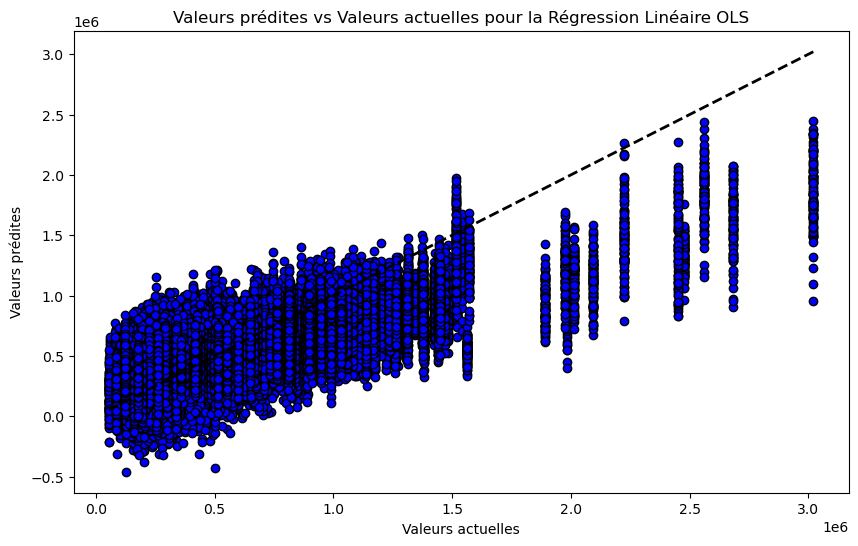

In [55]:
# Prédictions du modèle linéaire
y_pred_OLS_2 = linear_model.predict(X_rural_train)

# Graphique montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_OLS_2, alpha=1, color='blue', edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la Régression Linéaire OLS')
plt.show()

###### Regression de ridge 2


Best alpha for Ridge: 1000000.0
Coefficients du modèle Ridge: [ 201.99836268 -168.50880793  265.51503202 ...  408.9046454   229.32404605
  -22.16904401]
Ridge Train MSE: 97256131391.69272
Ridge Train MAE: 217967.48710287863
Ridge Train R^2: 0.07319102191606808


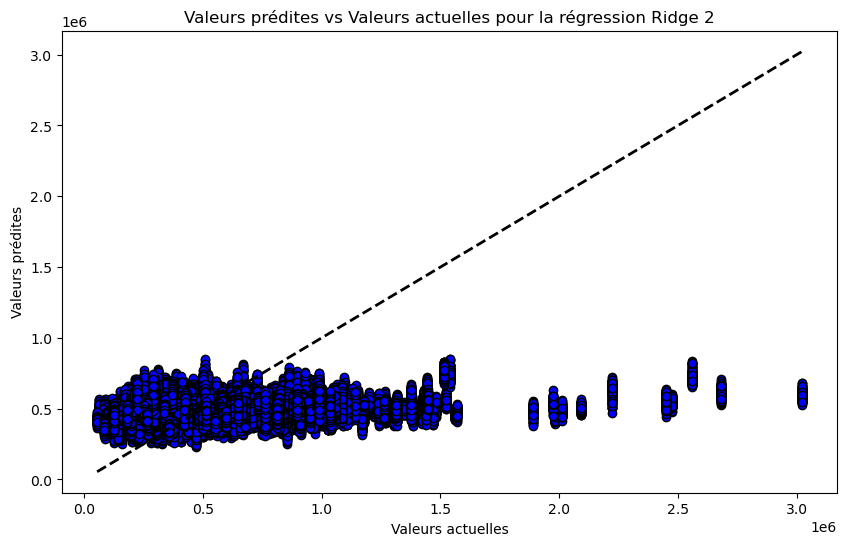

In [57]:
#Ridge regression

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-6, 6, 200)

# Configuration initiale et recherche du meilleur alpha avec GridSearchCV
ridge_model = Ridge()

# Limite de nombre d'itérations
max_iter = 100
found_optimal_alpha = False

for i in range(max_iter):
    ridge_cv = GridSearchCV(ridge_model, {'alpha': alphas}, scoring='r2', cv=5)
    ridge_cv.fit(X_rural_train, y)
    
    best_alpha_ridge = ridge_cv.best_estimator_.alpha
    
    if best_alpha_ridge is not None:
        found_optimal_alpha = True
        print(f'Best alpha for Ridge: {best_alpha_ridge}')
        break

if not found_optimal_alpha:
    print(f"Aucune valeur optimale pour alpha n'a été trouvée après {max_iter} itérations.")
else:
    # Entraîner le modèle de régression Ridge avec la meilleure valeur de alpha
    ridge_model = Ridge(alpha=best_alpha_ridge)
    ridge_model.fit(X_rural_train, y)

    # Extraction et affichage des coefficients du modèle Ridge
    coefficients_ridge = ridge_model.coef_
    print("Coefficients du modèle Ridge:", coefficients_ridge)

    # Prédictions Ridge
    y_pred_ridge_2 = ridge_model.predict(X_rural_train)

    # Évaluation du modèle Ridge
    mse_ridge = mean_squared_error(y, y_pred_ridge_2)
    r2_ridge = r2_score(y, y_pred_ridge_2)
    mae_ridge = mean_absolute_error(y, y_pred_ridge_2)

    print(f'Ridge Train MSE: {mse_ridge}')
    print(f'Ridge Train MAE: {mae_ridge}')
    print(f'Ridge Train R^2: {r2_ridge}')

    # Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred_ridge_2, alpha=1,color='blue', edgecolors='black')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
    plt.xlabel('Valeurs actuelles')
    plt.ylabel('Valeurs prédites')
    plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Ridge 2')
    plt.show()



In [58]:
import joblib
import os
# Chemin de sauvegarde du modèle Ridge
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
ridge_model_path = os.path.join(BASE_DIR,f'{Data_milieu}','ridge_model_sans_pca.pkl')
# Sauvegarder le modèle Ridge
joblib.dump(ridge_model, ridge_model_path)
print(f'Modèle Ridge sans reduction de dimension sauvegardé à: {ridge_model_path}')

Modèle Ridge sans reduction de dimension sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_rural\ridge_model_sans_pca.pkl


In [59]:

'''
import joblib
import os
# Chemin de chargement du modèle Ridge
ridge_model_loaded_path = os.path.join(BASE_DIR,f'{Data_milieu}','ridge_model_sans_pca.pkl')

# Recharger le modèle Ridge
ridge_model_loaded = joblib.load(ridge_model_loaded_path)
print("Modèle Ridge sans reduction de dimension chargé avec succès.")
'''


'\nimport joblib\nimport os\n# Chemin de chargement du modèle Ridge\nridge_model_loaded_path = os.path.join(BASE_DIR,f\'{Data_milieu}\',\'ridge_model_sans_pca.pkl\')\n\n# Recharger le modèle Ridge\nridge_model_loaded = joblib.load(ridge_model_loaded_path)\nprint("Modèle Ridge sans reduction de dimension chargé avec succès.")\n'

In [60]:
'''
import warnings
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning

# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-7, 7, 200)

# Limite de nombre d'itérations
max_iter = 1
found_optimal_alpha = False

# Filtrer et capturer les warnings de convergence comme des exceptions
with warnings.catch_warnings():
    warnings.filterwarnings('error', category=ConvergenceWarning)
    
    try:
        for i in range(max_iter):
            lasso_model = Lasso(max_iter=1)
            lasso_cv = GridSearchCV(lasso_model, {'alpha': alphas}, scoring='r2', cv=5)
            lasso_cv.fit(X, y)

            best_alpha_lasso = lasso_cv.best_estimator_.alpha

            if best_alpha_lasso is not None:
                found_optimal_alpha = True
                print(f'Best alpha for Lasso: {best_alpha_lasso}')
                break

        if not found_optimal_alpha:
            print(f"Aucune valeur optimale pour alpha n'a été trouvée après {max_iter} itérations.")
        else:
            # Entraîner le modèle de régression Lasso avec la meilleure valeur de alpha
            lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=10000)
            lasso_model.fit(X, y)

            # Extraction et affichage des coefficients du modèle Lasso
            coefficients_lasso = lasso_model.coef_
            print("Coefficients du modèle Lasso:", coefficients_lasso)

            # Prédictions Lasso
            y_pred_lasso_2 = lasso_model.predict(X)

            # Évaluation du modèle Lasso
            mse_lasso_2 = mean_squared_error(y, y_pred_lasso_2)
            r2_lasso_2 = r2_score(y, y_pred_lasso_2)
            mae_lasso_2 = mean_absolute_error(y, y_pred_lasso_2)

            print(f'Lasso Train MSE: {mse_lasso_2}')
            print(f'Lasso Train MAE: {mae_lasso_2}')
            print(f'Lasso Train R^2: {r2_lasso_2}')

            # Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
            plt.figure(figsize=(10, 6))
            plt.scatter(y, y_pred_lasso_2, alpha=0.5)
            plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
            plt.xlabel('Valeurs actuelles')
            plt.ylabel('Valeurs prédites')
            plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Lasso 2')
            plt.show()
    
    except ConvergenceWarning as cw:
        print("Arrêt de l'exécution : le modèle n'a pas convergé.")
        print(str(cw))
'''

'\nimport warnings\nfrom sklearn.linear_model import Lasso, LassoCV\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.exceptions import ConvergenceWarning\n\n# Définir une gamme de valeurs alpha à tester\nalphas = np.logspace(-7, 7, 200)\n\n# Limite de nombre d\'itérations\nmax_iter = 1\nfound_optimal_alpha = False\n\n# Filtrer et capturer les warnings de convergence comme des exceptions\nwith warnings.catch_warnings():\n    warnings.filterwarnings(\'error\', category=ConvergenceWarning)\n    \n    try:\n        for i in range(max_iter):\n            lasso_model = Lasso(max_iter=1)\n            lasso_cv = GridSearchCV(lasso_model, {\'alpha\': alphas}, scoring=\'r2\', cv=5)\n            lasso_cv.fit(X, y)\n\n            best_alpha_lasso = lasso_cv.best_estimator_.alpha\n\n            if best_alpha_lasso is not None:\n                found_opti

##### Calcul du taux de pauvreté sans réduction de dimension

In [61]:
import pandas as pd

# Création d'un nouveau DataFrame à partir des colonnes existantes
#df = pd.DataFrame({
#    'taille_menage': taille_menage,
#    'poids_menage': poids_menage,
#    'y': y,
#    'y_pred_lasso_2': y_pred_lasso_2,
#    'y_pred_OLS_2': y_pred_OLS_2,
#    'y_pred_ridge_2': y_pred_ridge_2
#})

df = pd.DataFrame({
    'taille_menage': taille_menage,
    'poids_menage': poids_menage,
    'y': y,
    'y_pred_OLS_2': y_pred_OLS_2,
    'y_pred_ridge_2': y_pred_ridge_2
})

# Ajout des colonnes binaires en fonction des seuils
df['y_binaire'] = (df['y'] < 345520).astype(int)
df['y_pred_OLS_2_binaire'] = (df['y_pred_OLS_2'] < 345520).astype(int)
#df['y_pred_lasso_2_binaire'] = (df['y_pred_lasso_2'] < 345520).astype(int)
df['y_pred_ridge_2_binaire'] = (df['y_pred_ridge_2'] < 345520).astype(int)

# Calcul des taux de pauvreté
total_menage = (df['taille_menage']*df['poids_menage']).sum()
taux_pauvrete_reel_echantillon = (df['taille_menage']*df['poids_menage'] * df['y_binaire']).sum() / total_menage
taux_pauvrete_OLS_2 = (df['taille_menage']*df['poids_menage']* df['y_pred_OLS_2_binaire']).sum() / total_menage
taux_pauvrete_ridge_2 = (df['taille_menage']*df['poids_menage']* df['y_pred_ridge_2_binaire']).sum() / total_menage
#taux_pauvrete_lasso_2 = (df['taille_menage']*df['poids_menage']* df['y_pred_lasso_2_binaire']).sum() / total_menage

# Affichage des résultats
print(f"Taux de pauvreté réel: {taux_pauvrete_reel:.2%}")
print(f"Taux de pauvreté réel avec l'échantillon du training set: {taux_pauvrete_reel_echantillon:.2%}")
print(f"Taux de pauvreté training prédit par OLS: {taux_pauvrete_OLS_2:.2%}")
print(f"Taux de pauvreté training prédit par Ridge: {taux_pauvrete_ridge_2:.2%}")
#print(f"Taux de pauvreté training prédit par Lasso: {taux_pauvrete_lasso_2:.2%}")


Taux de pauvreté réel: 54.66%
Taux de pauvreté réel avec l'échantillon du training set: 53.73%
Taux de pauvreté training prédit par OLS: 33.62%
Taux de pauvreté training prédit par Ridge: 2.05%


In [62]:
df

,taille_menage,poids_menage,y,y_pred_OLS_2,y_pred_ridge_2,y_binaire,y_pred_OLS_2_binaire,y_pred_ridge_2_binaire
0,2,268.36096,1117854.80,735186.658956,492038.044569,0,0,0
1,2,268.36096,1117854.80,758281.601804,529195.420942,0,0,0
2,2,268.36096,1117854.80,994243.325712,525068.388270,0,0,0
3,2,268.36096,1117854.80,887113.913790,493346.967541,0,0,0
4,2,268.36096,1117854.80,788107.200216,504849.010732,0,0,0
...,...,...,...,...,...,...,...,...
128795,15,220.62573,124090.74,224494.731476,459000.674818,1,1,0
128796,15,220.62573,124090.74,458231.461203,399289.033115,1,0,0
128797,15,220.62573,124090.74,206904.766804,477375.355813,1,1,0
128798,15,220.62573,124090.74,401022.142422,412271.974661,1,0,0


#### OLS avec le logarithm de la consommation par tete avec réduction de la dimension

Coefficients du modèle : [ 2.37083065e-03 -6.03117877e-04  2.50656254e-03  2.48096212e-03
  3.13341297e-03 -2.53199553e-04  2.41533811e-03  3.96969102e-04
 -3.67159240e-03  2.95059982e-03 -2.85530549e-03 -2.77583351e-04
 -2.42059220e-03 -2.37545496e-03 -9.40988893e-04  4.92178021e-03
  4.37396069e-03  2.42865782e-03 -5.76137268e-05 -7.94561636e-04
  5.07142544e-04 -1.18946393e-03  5.82166900e-04 -8.76715392e-04
  2.87903421e-05  1.68426728e-03  7.72829527e-04  1.68085364e-03
  6.14570236e-03  6.39853352e-03  2.46835112e-03 -2.30199068e-03
  9.93969479e-04  3.22126281e-03  5.89780070e-05  3.25580287e-03
  9.05576700e-04 -8.20267044e-04  5.48152397e-03  4.78511991e-03
  1.99108035e-03  4.51028292e-03 -7.86562736e-04  1.37977103e-03
 -3.80441373e-03 -5.57711486e-03 -4.03958032e-03 -3.18709718e-04
 -2.17057447e-03 -6.53467965e-04  1.00293190e-03  3.00790777e-03
  1.90069583e-04 -1.57227033e-03 -3.73410270e-04 -2.80204704e-03
 -4.40399061e-03 -2.92228891e-03  3.43310646e-03  2.15589564e-04


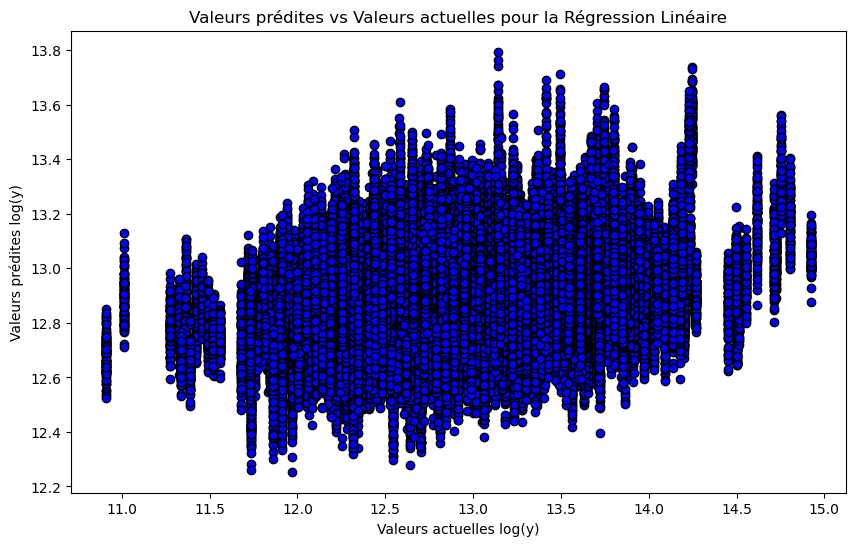

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm

# Transformation de la variable cible y en log(y)
y_log = np.log(y)

# Modèle de régression linéaire avec X_pca en tant que prédicteurs et log(y) comme variable cible.
linear_model_pca_log = LinearRegression()
linear_model_pca_log.fit(X_pca, y_log)

# Coefficients de la régression
coefficients = linear_model_pca_log.coef_
print("Coefficients du modèle :", coefficients)

# Ajout d'un intercept à X_pca
X_pca_sm = sm.add_constant(X_pca)

# Ajustement du modèle avec statsmodels pour log(y)
model_sm_pca_log = sm.OLS(y_log, X_pca_sm)
results = model_sm_pca_log.fit()

# Affichage du résumé
print(results.summary())

# Prédictions du modèle linéaire pour log(y)
y_pred_OLS_log = linear_model_pca_log.predict(X_pca)

# Calcul du MSE et du MAE
mse = mean_squared_error(y_log, y_pred_OLS_log)
mae = mean_absolute_error(y_log, y_pred_OLS_log)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# Graphique montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y_log, y_pred_OLS_log, alpha=1, color='blue', edgecolors='k')
plt.xlabel('Valeurs actuelles log(y)')
plt.ylabel('Valeurs prédites log(y)')
plt.title('Valeurs prédites vs Valeurs actuelles pour la Régression Linéaire')
plt.show()


In [64]:
import pandas as pd
# Créer un DataFrame 
df_results_OLS_log = pd.DataFrame({
    'y': y,
    'y_log': y_log,
    'y_pred_OLS_log': y_pred_OLS_log
})
# Afficher les 100 premières valeurs
print(df_results_OLS_log.head(100))


            y      y_log  y_pred_OLS_log
0   1117854.8  13.926922       12.853212
1   1117854.8  13.926922       12.943239
2   1117854.8  13.926922       12.900300
3   1117854.8  13.926922       12.855659
4   1117854.8  13.926922       12.866757
..        ...        ...             ...
95  1117854.8  13.926922       12.855079
96  1117854.8  13.926922       13.081344
97  1117854.8  13.926922       12.815439
98  1117854.8  13.926922       13.098244
99  1117854.8  13.926922       13.015894

[100 rows x 3 columns]


In [65]:
import joblib
import pickle
# Chemin de sauvegarde des modèles
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'

# Exportation du modèle OLS de statsmodels avec PCA pour ré-utilisation
model_sm_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\model_sm_pca_log.pkl'
with open(model_sm_pca_log_path, 'wb') as file:
    pickle.dump(model_sm_pca_log, file)
print(f'Modèle statsmodels (PCA Log) sauvegardé à: {model_sm_pca_log_path}')

Modèle statsmodels (PCA Log) sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_rural\model_sm_pca_log.pkl


In [66]:
'''
import joblib
import pickle
# Chemin de chargement des modèles
BASE_DIR = r'D:\Poverty_Predict'
# Chargement du modèle OLS de statsmodels avec PCA log
model_sm_pca_log_path =f'{BASE_DIR}\\{Data_milieu}\\model_sm_pca_log.pkl'
with open(model_sm_pca_log_path, 'rb') as file:
    model_sm_pca_log_loaded = pickle.load(file)
print("Modèle statsmodels (PCA Log) chargé avec succès.")
'''

'\nimport joblib\nimport pickle\n# Chemin de chargement des modèles\nBASE_DIR = r\'D:\\Poverty_Predict\'\n# Chargement du modèle OLS de statsmodels avec PCA log\nmodel_sm_pca_log_path =f\'{BASE_DIR}\\{Data_milieu}\\model_sm_pca_log.pkl\'\nwith open(model_sm_pca_log_path, \'rb\') as file:\n    model_sm_pca_log_loaded = pickle.load(file)\nprint("Modèle statsmodels (PCA Log) chargé avec succès.")\n'

#### Ridge avec le logarithm de la consommation par tete avec réduction de la dimension

Best alpha for Ridge: 1000000.0
Coefficients du modèle Ridge: [ 2.32166917e-03 -5.85703084e-04  2.42364398e-03  2.39193217e-03
  3.00713769e-03 -2.42101863e-04  2.30307032e-03  3.76554980e-04
 -3.44633356e-03  2.75635294e-03 -2.65814011e-03 -2.57616043e-04
 -2.22471311e-03 -2.17464301e-03 -8.61038048e-04  4.45976402e-03
  3.93548266e-03  2.17960612e-03 -5.13726071e-05 -6.98117684e-04
  4.44535528e-04 -1.03389767e-03  4.97695078e-04 -7.46376959e-04
  2.42790187e-05  1.41678595e-03  6.39193144e-04  1.36543826e-03
  4.94574206e-03  5.12939517e-03  1.95657154e-03 -1.79863442e-03
  7.69069050e-04  2.49107704e-03  4.48606923e-05  2.43804498e-03
  6.75429562e-04 -6.08669787e-04  3.99737997e-03  3.43941850e-03
  1.42403890e-03  3.19909428e-03 -5.53327314e-04  9.63629358e-04
 -2.63269936e-03 -3.81401908e-03 -2.73334994e-03 -2.13644716e-04
 -1.42873301e-03 -4.27069246e-04  6.43806839e-04  1.90509578e-03
  1.18926509e-04 -9.71779849e-04 -2.29570834e-04 -1.69453134e-03
 -2.62180377e-03 -1.73219809

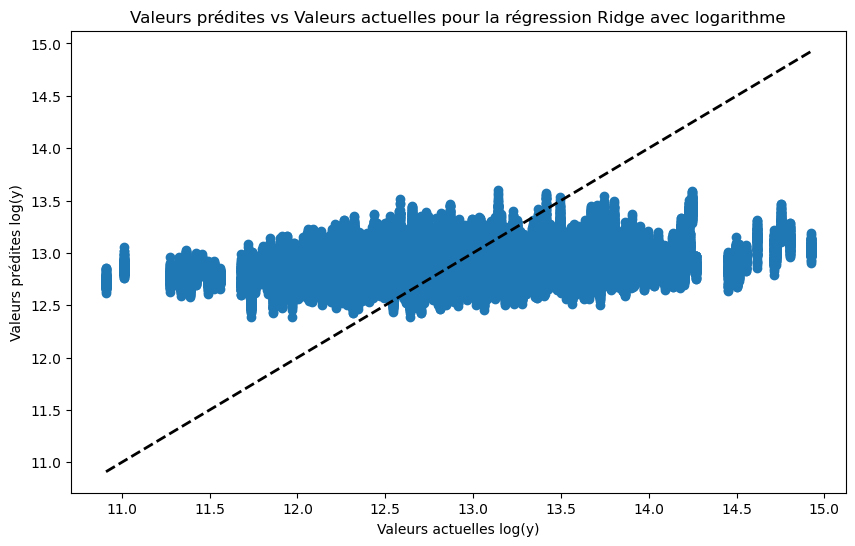

In [67]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Transformation de la variable cible y en log(y)
y_log = np.log(y)

# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-6, 6, 200)

# Configuration initiale et recherche du meilleur alpha avec GridSearchCV
ridge_model_pca_log = Ridge()
ridge_cv = GridSearchCV(ridge_model_pca_log, {'alpha': alphas}, scoring='r2', cv=5)
ridge_cv.fit(X_pca, y_log)

# Meilleure valeur de alpha pour Ridge
best_alpha_ridge = ridge_cv.best_estimator_.alpha
print(f'Best alpha for Ridge: {best_alpha_ridge}') 

# Entraîner le modèle de régression Ridge avec la meilleure valeur de alpha
ridge_model_pca_log = Ridge(alpha=best_alpha_ridge)
ridge_model_pca_log.fit(X_pca, y_log)

# Extraction et affichage des coefficients du modèle Ridge
coefficients_ridge = ridge_model_pca_log.coef_
print("Coefficients du modèle Ridge:", coefficients_ridge)

# Prédictions Ridge pour log(y)
y_pred_ridge_log = ridge_model_pca_log.predict(X_pca)

# Évaluation du modèle Ridge
mse_pca_ridge = mean_squared_error(y_log, y_pred_ridge_log)
r2_pca_ridge = r2_score(y_log, y_pred_ridge_log)
mae_pca_ridge = mean_absolute_error(y_log, y_pred_ridge_log)

print(f'Ridge Train MSE: {mse_pca_ridge}')
print(f'Ridge Train MAE: {mae_pca_ridge}')
print(f'Ridge Train R^2: {r2_pca_ridge}')

# Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y_log, y_pred_ridge_log, alpha=1)
plt.plot([y_log.min(), y_log.max()], [y_log.min(), y_log.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles log(y)')
plt.ylabel('Valeurs prédites log(y)')
plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Ridge avec logarithme')
plt.show()


In [68]:
import pandas as pd
# Créer un DataFrame 
df_results_ridge_log = pd.DataFrame({
    'y': y,
    'y_log': y_log,
    'y_pred_ridge_log': y_pred_ridge_log
})
# Afficher les 100 premières valeurs
print(df_results_ridge_log.head(100))

            y      y_log  y_pred_ridge_log
0   1117854.8  13.926922         12.852125
1   1117854.8  13.926922         12.919018
2   1117854.8  13.926922         12.908775
3   1117854.8  13.926922         12.886386
4   1117854.8  13.926922         12.893038
..        ...        ...               ...
95  1117854.8  13.926922         12.888398
96  1117854.8  13.926922         13.065402
97  1117854.8  13.926922         12.849543
98  1117854.8  13.926922         13.052757
99  1117854.8  13.926922         13.015824

[100 rows x 3 columns]


In [69]:
import joblib
import pickle
# Chemin de sauvegarde des modèles
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'

# Exportation du modèle Ridge avec PCA pour ré-utilisation
ridge_model_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\ridge_model_pca_log.pkl'
joblib.dump(ridge_model_pca_log, ridge_model_pca_log_path)
print(f'Modèle Ridge (PCA Log) sauvegardé à: {ridge_model_pca_log_path}')

Modèle Ridge (PCA Log) sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_rural\ridge_model_pca_log.pkl


In [70]:
'''
import joblib
import pickle
# Chemin de chargement des modèles
BASE_DIR = r'D:\Poverty_Predict'
# Chargement du modèle Ridge avec PCA log
ridge_model_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\ridge_model_pca_log.pkl'
ridge_model_pca_log_loaded = joblib.load(ridge_model_pca_log_path)
print("Modèle Ridge (PCA Log) chargé avec succès.")
'''

'\nimport joblib\nimport pickle\n# Chemin de chargement des modèles\nBASE_DIR = r\'D:\\Poverty_Predict\'\n# Chargement du modèle Ridge avec PCA log\nridge_model_pca_log_path = f\'{BASE_DIR}\\{Data_milieu}\\ridge_model_pca_log.pkl\'\nridge_model_pca_log_loaded = joblib.load(ridge_model_pca_log_path)\nprint("Modèle Ridge (PCA Log) chargé avec succès.")\n'

Best alpha for Lasso: 0.1011637979766207
Coefficients du modèle Lasso: [ 0.00209492 -0.0002157   0.00206078  0.00199598  0.00258626 -0.
  0.00178017  0.         -0.00281993  0.00203235 -0.00188882 -0.
 -0.00127335 -0.00117224 -0.          0.00357193  0.00292221  0.0009398
 -0.         -0.          0.         -0.          0.         -0.
  0.          0.          0.          0.          0.00298432  0.00317462
  0.         -0.          0.          0.          0.          0.
  0.         -0.          0.00064379  0.          0.          0.
 -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
 -0.         -0.          0.          0.         -0.          0.
  0.          0.          0.         -0.          0.          0.
 -0.         -0.         -0.          0.         -0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.
 -0.

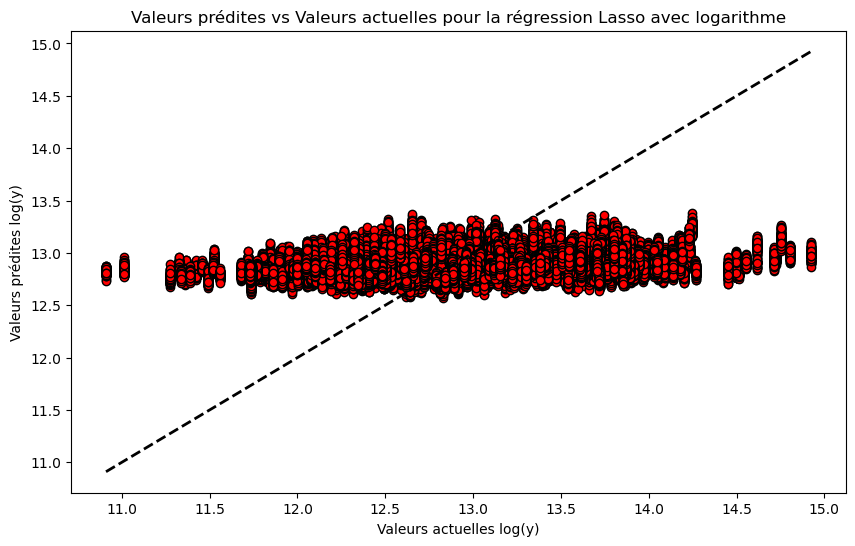

In [71]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Transformation de la variable cible y en log(y)
y_log = np.log(y)

# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-6, 6, 200)

# Configuration initiale et recherche du meilleur alpha avec GridSearchCV
lasso_model_pca_log = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso_model_pca_log, {'alpha': alphas}, scoring='r2', cv=5)
lasso_cv.fit(X_pca, y_log)

# Meilleure valeur de alpha pour Lasso
best_alpha_lasso = lasso_cv.best_estimator_.alpha
print(f'Best alpha for Lasso: {best_alpha_lasso}')

# Entraîner le modèle de régression Lasso avec la meilleure valeur de alpha
lasso_model_pca_log = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_model_pca_log.fit(X_pca, y_log)

# Extraction et affichage des coefficients du modèle Lasso
coefficients_lasso = lasso_model_pca_log.coef_
print("Coefficients du modèle Lasso:", coefficients_lasso)

# Prédictions Lasso pour log(y)
y_pred_lasso_log = lasso_model_pca_log.predict(X_pca)

# Évaluation du modèle Lasso
mse_pca_lasso = mean_squared_error(y_log, y_pred_lasso_log)
r2_pca_lasso = r2_score(y_log, y_pred_lasso_log)
mae_pca_lasso = mean_absolute_error(y_log, y_pred_lasso_log)

print(f'Lasso Train MSE: {mse_pca_lasso}')
print(f'Lasso Train MAE: {mae_pca_lasso}')
print(f'Lasso Train R^2: {r2_pca_lasso}')

# Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y_log, y_pred_lasso_log, alpha=1,color='red',edgecolors='black')
plt.plot([y_log.min(), y_log.max()], [y_log.min(), y_log.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles log(y)')
plt.ylabel('Valeurs prédites log(y)')
plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Lasso avec logarithme')
plt.show()


In [72]:
import joblib
import pickle
# Chemin de sauvegarde des modèles

BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
# Exportation du modèle Lasso avec PCA pour ré-utilisation
lasso_model_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\lasso_model_pca_log.pkl'
joblib.dump(lasso_model_pca_log, lasso_model_pca_log_path)
print(f'Modèle Lasso (PCA Log) sauvegardé à: {lasso_model_pca_log_path}')

Modèle Lasso (PCA Log) sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_rural\lasso_model_pca_log.pkl


In [73]:
'''
import joblib
import pickle
# Chemin de chargement des modèles
BASE_DIR = r'D:\Poverty_Predict'
# Chargement du modèle Lasso avec PCA log
lasso_model_pca_log_path ='f'{BASE_DIR}\\{Data_milieu}\\lasso_model_pca_log.pkl'
lasso_model_pca_log_loaded = joblib.load(lasso_model_pca_log_path)
print("Modèle Lasso (PCA Log) chargé avec succès.")
'''

'\nimport joblib\nimport pickle\n# Chemin de chargement des modèles\nBASE_DIR = r\'D:\\Poverty_Predict\'\n# Chargement du modèle Lasso avec PCA log\nlasso_model_pca_log_path =\'f\'{BASE_DIR}\\{Data_milieu}\\lasso_model_pca_log.pkl\'\nlasso_model_pca_log_loaded = joblib.load(lasso_model_pca_log_path)\nprint("Modèle Lasso (PCA Log) chargé avec succès.")\n'

In [74]:
import pandas as pd
# Créer un DataFrame 
df_results_ridge_log = pd.DataFrame({
    'y': y,
    'y_log': y_log,
    'y_pred_lasso_log': y_pred_lasso_log
})
# Afficher les 100 premières valeurs
print(df_results_ridge_log.head(100))

            y      y_log  y_pred_lasso_log
0   1117854.8  13.926922         12.937065
1   1117854.8  13.926922         12.926750
2   1117854.8  13.926922         12.956768
3   1117854.8  13.926922         12.992812
4   1117854.8  13.926922         12.986205
..        ...        ...               ...
95  1117854.8  13.926922         13.017564
96  1117854.8  13.926922         13.076600
97  1117854.8  13.926922         12.971777
98  1117854.8  13.926922         13.014675
99  1117854.8  13.926922         13.046503

[100 rows x 3 columns]


In [75]:
import pandas as pd

# Création d'un nouveau DataFrame à partir des colonnes existantes
df2 = pd.DataFrame({
    'taille_menage': taille_menage,
    'poids_menage': poids_menage,
    'y': y,
	'y_log': y_log,
	'y_pred_OLS_log': y_pred_OLS_log,
    'y_pred_lasso_log': y_pred_lasso_log,
    'y_pred_ridge_log': y_pred_ridge_log
})

# Ajout des colonnes binaires en fonction des seuils
seuil=np.log(345520)
df2['y_log_binaire'] = (df2['y_log'] < seuil).astype(int)
df2['y_pred_OLS_log_binaire'] = (df2['y_pred_OLS_log'] < seuil).astype(int)
df2['y_pred_lasso_log_binaire'] = (df2['y_pred_lasso_log'] < seuil).astype(int)
df2['y_pred_ridge_log_binaire'] = (df2['y_pred_ridge_log'] < seuil).astype(int)

# Calcul des taux de pauvreté
total_menage = (df2['taille_menage']*df2['poids_menage']).sum()
taux_pauvrete_reel_echantillon = (df2['taille_menage']*df2['poids_menage'] * df2['y_log_binaire']).sum() / total_menage
taux_pauvrete_OLS_log = (df2['taille_menage']*df2['poids_menage']* df2['y_pred_OLS_log_binaire']).sum() / total_menage
taux_pauvrete_ridge_log = (df2['taille_menage']*df2['poids_menage']* df2['y_pred_ridge_log_binaire']).sum() / total_menage
taux_pauvrete_lasso_log = (df2['taille_menage']*df2['poids_menage']* df2['y_pred_lasso_log_binaire']).sum() / total_menage

# Affichage des résultats
print(f"Taux de pauvreté réel: {taux_pauvrete_reel:.2%}")
print(f"Taux de pauvreté réel avec l'échantillon du training set: {taux_pauvrete_reel_echantillon:.2%}")
print(f"Taux de pauvreté training prédit par OLS logarithme consommation par tete: {taux_pauvrete_OLS_log:.2%}")
print(f"Taux de pauvreté training prédit par Ridge logarithme consommation par tete: {taux_pauvrete_ridge_log:.2%}")
print(f"Taux de pauvreté training prédit par Lasso logarithme consommation par tete: {taux_pauvrete_lasso_log:.2%}")

Taux de pauvreté réel: 54.66%
Taux de pauvreté réel avec l'échantillon du training set: 53.73%
Taux de pauvreté training prédit par OLS logarithme consommation par tete: 21.69%
Taux de pauvreté training prédit par Ridge logarithme consommation par tete: 16.64%
Taux de pauvreté training prédit par Lasso logarithme consommation par tete: 6.96%


#### OLS avec le logarithm de la consommation par tete sans réduction de la dimension


Coefficients du modèle : [ 5044.01556815  3615.96799726 -5511.25694736 ... -1684.50279568
  3491.19036162 -2825.89868244]
                            OLS Regression Results                            
Dep. Variable:                  pcexp   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     30.18
Date:                Thu, 29 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:35:10   Log-Likelihood:                -69600.
No. Observations:              128800   AIC:                         1.473e+05
Df Residuals:                  124736   BIC:                         1.870e+05
Df Model:                        4063                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------

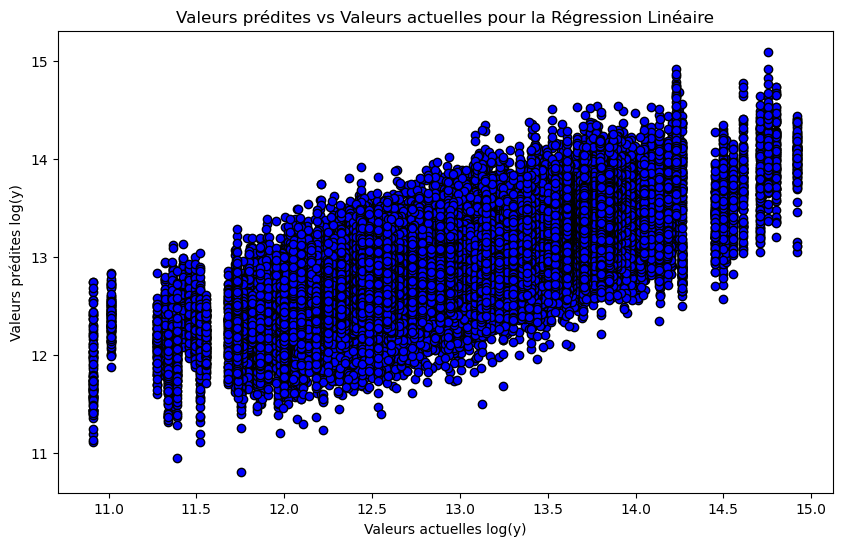

            y      y_log  y_pred_OLS_log_sans_pca
0   1117854.8  13.926922                13.335407
1   1117854.8  13.926922                13.351761
2   1117854.8  13.926922                13.816735
3   1117854.8  13.926922                13.680476
4   1117854.8  13.926922                13.427819
..        ...        ...                      ...
95  1117854.8  13.926922                13.680037
96  1117854.8  13.926922                13.914105
97  1117854.8  13.926922                13.369469
98  1117854.8  13.926922                13.665950
99  1117854.8  13.926922                13.883765

[100 rows x 3 columns]


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import pandas as pd
import pickle



# Transformation de la variable cible y en log(y)
y_log = np.log(y)

# Modèle de régression linéaire avec X en tant que prédicteurs et log(y) comme variable cible.
linear_model_sans_pca_log = LinearRegression()
linear_model_sans_pca_log.fit(X_rural_train, y_log)

# Coefficients de la régression
coefficients = linear_model_sans_pca_log.coef_
print("Coefficients du modèle :", coefficients)

# Ajout d'un intercept à X
X_sm = sm.add_constant(X_rural_train)

# Ajustement du modèle avec statsmodels pour log(y)
model_sm_sans_pca_log = sm.OLS(y_log, X_sm)
results = model_sm_sans_pca_log.fit()

# Affichage du résumé
print(results.summary())

# Prédictions du modèle linéaire pour log(y)
y_pred_OLS_log_sans_pca = linear_model_sans_pca_log.predict(X_rural_train)

# Calcul du MSE et du MAE
mse = mean_squared_error(y_log, y_pred_OLS_log_sans_pca)
mae = mean_absolute_error(y_log, y_pred_OLS_log_sans_pca)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# Graphique montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y_log, y_pred_OLS_log_sans_pca, alpha=1, color='blue', edgecolors='k')
plt.xlabel('Valeurs actuelles log(y)')
plt.ylabel('Valeurs prédites log(y)')
plt.title('Valeurs prédites vs Valeurs actuelles pour la Régression Linéaire')
plt.show()

# Créer un DataFrame 
df_results_OLS_log_sans_pca = pd.DataFrame({
    'y': y,
    'y_log': y_log,
    'y_pred_OLS_log_sans_pca': y_pred_OLS_log_sans_pca
})
# Afficher les 100 premières valeurs
print(df_results_OLS_log_sans_pca.head(100))




In [77]:
# Chemin de sauvegarde des modèles
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
# Exportation du modèle OLS de statsmodels sans PCA pour ré-utilisation
model_sm_sans_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\model_sm_sans_pca_log.pkl'
with open(model_sm_sans_pca_log_path, 'wb') as file:
    pickle.dump(model_sm_sans_pca_log, file)
print(f'Modèle statsmodels (sans PCA Log) sauvegardé à: {model_sm_sans_pca_log_path}')



Modèle statsmodels (sans PCA Log) sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_rural\model_sm_sans_pca_log.pkl


In [78]:
''' 
model_sm_sans_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\model_sm_sans_pca_log.pkl'
# Chargement du modèle OLS de statsmodels sans PCA log
with open(model_sm_sans_pca_log_path, 'rb') as file:
    model_sm_sans_pca_log_loaded = pickle.load(file)
print("Modèle statsmodels (sans PCA Log) chargé avec succès.")
'''

' \nmodel_sm_sans_pca_log_path = f\'{BASE_DIR}\\{Data_milieu}\\model_sm_sans_pca_log.pkl\'\n# Chargement du modèle OLS de statsmodels sans PCA log\nwith open(model_sm_sans_pca_log_path, \'rb\') as file:\n    model_sm_sans_pca_log_loaded = pickle.load(file)\nprint("Modèle statsmodels (sans PCA Log) chargé avec succès.")\n'

#### Regression de ridge avec le logarithm de la consommation par tete sans réduction de la dimension


Best alpha for Ridge: 1000000.0
Coefficients du modèle Ridge: [ 0.00052362 -0.00025544  0.0004776  ...  0.00065312  0.00059313
 -0.00017068]
Ridge Train MSE: 0.31548028314867776
Ridge Train MAE: 0.4471585319259457
Ridge Train R^2: 0.07789672480490506


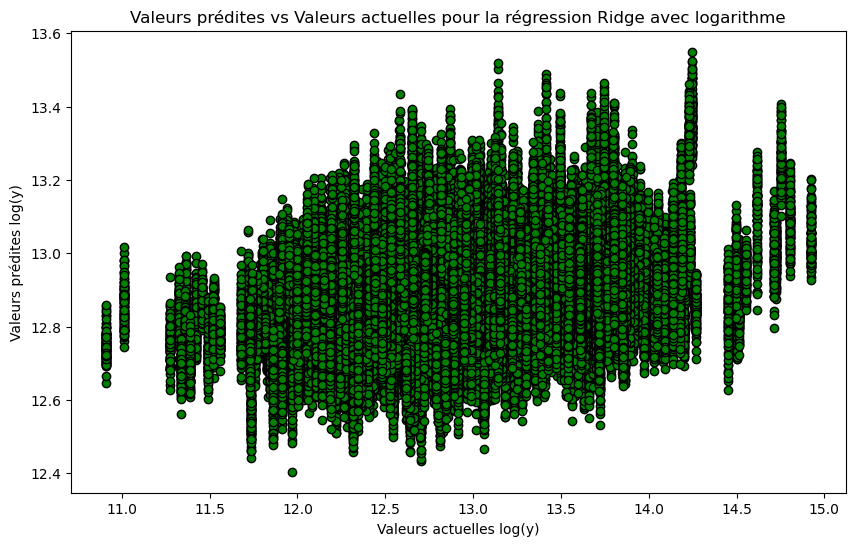

            y      y_log  y_pred_ridge_log_sans_pca
0   1117854.8  13.926922                  12.879347
1   1117854.8  13.926922                  12.923661
2   1117854.8  13.926922                  12.928364
3   1117854.8  13.926922                  12.907825
4   1117854.8  13.926922                  12.916700
..        ...        ...                        ...
95  1117854.8  13.926922                  12.904463
96  1117854.8  13.926922                  13.068925
97  1117854.8  13.926922                  12.880663
98  1117854.8  13.926922                  13.028984
99  1117854.8  13.926922                  13.016983

[100 rows x 3 columns]


In [79]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import pickle


# Transformation de la variable cible y en log(y)
y_log = np.log(y)

# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-6, 6, 200)

# Configuration initiale et recherche du meilleur alpha avec GridSearchCV
ridge_model_sans_pca_log = Ridge()
ridge_cv = GridSearchCV(ridge_model_sans_pca_log, {'alpha': alphas}, scoring='r2', cv=5)
ridge_cv.fit(X_rural_train, y_log)

# Meilleure valeur de alpha pour Ridge
best_alpha_ridge = ridge_cv.best_estimator_.alpha
print(f'Best alpha for Ridge: {best_alpha_ridge}') 

# Entraîner le modèle de régression Ridge avec la meilleure valeur de alpha
ridge_model_sans_pca_log = Ridge(alpha=best_alpha_ridge)
ridge_model_sans_pca_log.fit(X_rural_train, y_log)

# Extraction et affichage des coefficients du modèle Ridge
coefficients_ridge = ridge_model_sans_pca_log.coef_
print("Coefficients du modèle Ridge:", coefficients_ridge)

# Prédictions Ridge pour log(y)
y_pred_ridge_log_sans_pca = ridge_model_sans_pca_log.predict(X_rural_train)

# Évaluation du modèle Ridge
mse_sans_pca_ridge = mean_squared_error(y_log, y_pred_ridge_log_sans_pca)
r2_sans_pca_ridge = r2_score(y_log, y_pred_ridge_log_sans_pca)
mae_sans_pca_ridge = mean_absolute_error(y_log, y_pred_ridge_log_sans_pca)

print(f'Ridge Train MSE: {mse_sans_pca_ridge}')
print(f'Ridge Train MAE: {mae_sans_pca_ridge}')
print(f'Ridge Train R^2: {r2_sans_pca_ridge}')

# Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y_log, y_pred_ridge_log_sans_pca, alpha=1,color='green',edgecolors='black')
plt.xlabel('Valeurs actuelles log(y)')
plt.ylabel('Valeurs prédites log(y)')
plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Ridge avec logarithme')
plt.show()

# Créer un DataFrame 
df_results_ridge_log_sans_pca = pd.DataFrame({
    'y': y,
    'y_log': y_log,
    'y_pred_ridge_log_sans_pca': y_pred_ridge_log_sans_pca
})
# Afficher les 100 premières valeurs
print(df_results_ridge_log_sans_pca.head(100))



In [80]:
# Chemin de sauvegarde des modèles
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'

# Exportation du modèle Ridge sans PCA pour ré-utilisation
ridge_model_sans_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\ridge_model_sans_pca_log.pkl'
joblib.dump(ridge_model_sans_pca_log, ridge_model_sans_pca_log_path)
print(f'Modèle Ridge (sans PCA Log) sauvegardé à: {ridge_model_sans_pca_log_path}')




Modèle Ridge (sans PCA Log) sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_rural\ridge_model_sans_pca_log.pkl


In [81]:
'''
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'

# Chargement du modèle Ridge sans PCA log
ridge_model_sans_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\ridge_model_sans_pca_log.pkl'

ridge_model_sans_pca_log_loaded = joblib.load(ridge_model_sans_pca_log_path)
print("Modèle Ridge (sans PCA Log) chargé avec succès.")
'''

'\nBASE_DIR = r\'D:\\Poverty_Predict_Par_Milieu\'\n\n# Chargement du modèle Ridge sans PCA log\nridge_model_sans_pca_log_path = f\'{BASE_DIR}\\{Data_milieu}\\ridge_model_sans_pca_log.pkl\'\n\nridge_model_sans_pca_log_loaded = joblib.load(ridge_model_sans_pca_log_path)\nprint("Modèle Ridge (sans PCA Log) chargé avec succès.")\n'

In [82]:
import pandas as pd
import numpy as np

# Supposons que taille_menage, poids_menage, y, y_log, y_pred_OLS_log_sans_pca et y_pred_ridge_log_sans_pca sont déjà définis ici

# Création d'un nouveau DataFrame à partir des colonnes existantes
df3 = pd.DataFrame({
    'taille_menage': taille_menage,
    'poids_menage': poids_menage,
    'y': y,
    'y_log': y_log,
    'y_pred_OLS_log_sans_pca': y_pred_OLS_log_sans_pca,
    'y_pred_ridge_log_sans_pca': y_pred_ridge_log_sans_pca
})

# Définir le seuil en utilisant la valeur log(345520)
seuil = np.log(345520)

# Ajouter les colonnes binaires en fonction des seuils
df3['y_log_binaire'] = (df3['y_log'] < seuil).astype(int)
df3['y_pred_OLS_log_sans_pca_binaire'] = (df3['y_pred_OLS_log_sans_pca'] < seuil).astype(int)
df3['y_pred_ridge_log_sans_pca_binaire'] = (df3['y_pred_ridge_log_sans_pca'] < seuil).astype(int)

# Calcul des taux de pauvreté
total_menage = (df3['taille_menage'] * df3['poids_menage']).sum()
taux_pauvrete_reel_echantillon = (df3['taille_menage'] * df3['poids_menage'] * df3['y_log_binaire']).sum() / total_menage
taux_pauvrete_OLS_log = (df3['taille_menage'] * df3['poids_menage'] * df3['y_pred_OLS_log_sans_pca_binaire']).sum() / total_menage
taux_pauvrete_ridge_log = (df3['taille_menage'] * df3['poids_menage'] * df3['y_pred_ridge_log_sans_pca_binaire']).sum() / total_menage

# Affichage des résultats
print(f"Taux de pauvreté réel: {taux_pauvrete_reel_echantillon:.2%}")
print(f"Taux de pauvreté training prédit par OLS logarithme consommation par tête (sans PCA): {taux_pauvrete_OLS_log:.2%}")
print(f"Taux de pauvreté training prédit par Ridge logarithme consommation par tête (sans PCA): {taux_pauvrete_ridge_log:.2%}")


Taux de pauvreté réel: 53.73%
Taux de pauvreté training prédit par OLS logarithme consommation par tête (sans PCA): 44.16%
Taux de pauvreté training prédit par Ridge logarithme consommation par tête (sans PCA): 14.74%
